In [250]:
# dependencies

# functionalities
import pandas as pd
import re
import random
import datetime
import numpy as np
from collections import Counter
import holidays
import json

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from vat import VAT

# NLP
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import openai
from sklearn.cluster import KMeans

# Introduction



## Introduction of dataset

### background
SOP, or security of payment, is an Act to provide entitlements to progress payments for persons who carry out construction work or who supply related goods and services under construction contracts.  

The object of this Act is to ensure that any person who undertakes to carry out construction work or who undertakes to supply related goods and services under a construction contract is entitled to receive, and is able to recover, progress payments in relation to the carrying out of that work and the supplying of those goods and services.

### application process

## Research Question and Target audience

Our target audience would be the potential users of the SOP service, we strive to answer the following question for them: 

> _For a potential user of the SOP service, given its before application condition, should it use the SOP service?_

We'll address this question by considering 3 criteria:
1. Given the potential claimant's current situation, what is the expected adjudicated amount? (as a % of its claimed amount)
2. Given the potential claimant’s current situation, what % of the adjudicator fee is it expecting to pay? (beta regression because response variable is a %)
3. What is the expected adjudicator fee as a % of my claimed amount
4. Is potential claimant's work provided covered under SOP? (NLP)
5. What is the potential claimant’s standing among all the previous applicants? (visualisation)

Another potential audience of our research is Victorian government because we might expose some of SOP act's merit during our research which will encourage more people to use adjudication service instead of taking to the legal path, thus saving public resource.


# Data Wrangling

In [251]:
df_original = pd.read_excel('./assg2/datasets-2023/adjudication-data/Adjudication-Activity-Statistics-2021-2022-Financial-Year.XLSX', index_col = 0)
df = df_original.copy(deep=True)
df.head()

,Application date,Acceptance date,Description of project and contract works,Project postcode,Claimed amount (ex GST),Payment Schedule provided,Payment Schedule provision,Amount of Payment Schedule (ex GST),Section of Act application made under,Section 18(2) notice issued,...,ANA application fee (ex GST),Adjudication Certificate issued,Adjudication Certificate fee (ex GST),Date Adjudication Certificate issued,Other ANA fees,Value of Other ANA fees (ex GST),Adjudicator fee charged,ANA percentage of Adjudicator fee %,ANA fee from Adjudicator fee (ex GST),Adjudicator share of adjudicator fee - amount
No. of App.,,,,,,,,,,,,,,,,,,,,,
1,2021-05-11,2021-05-14,Concrete polishing,3186,11327.27,No,S18,NaN,s.18(1)(b),Yes,...,0,Yes,100,2021-12-20 00:00:00,NaN,NaN,Yes,0.33,330,660
2,2021-05-21,2021-05-26,Design and construction works,3039,202230.09,Yes,s15,0.0,s.18(1)(a)(i),NaN,...,0,Yes,0,2021-08-31 00:00:00,NaN,NaN,Yes,0.15,5313,30107
3,2021-06-10,2021-06-16,Supply and installation of joinery,3186,19456.93,Yes,s18,0.0,s.18(1)(b),Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,No,0.33,777.27,1554.55
4,2021-06-21,2021-06-24,Shop fit-out,3141,73212.33,No,s18,NaN,s.18(1)(b),Yes,...,0,Yes,500,2021-07-16 00:00:00,NaN,NaN,Yes,0.333333,1909.09,3818.18
5,2021-06-24,2021-06-29,Installation of new roof and gutters,3201,2266.12,Yes,s15,0.0,s.18(1)(a)(i),NaN,...,0,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,0


In [252]:
df['Claimant advisers'].value_counts(dropna=False)

None              190
Solicitors         96
Claim preparer     28
Consultant          7
Not known           3
Name: Claimant advisers, dtype: int64

In [253]:
df.columns

Index(['Application date', 'Acceptance date',
       'Description of project and contract works', 'Project postcode',
       'Claimed amount (ex GST)', 'Payment Schedule provided',
       'Payment Schedule provision', 'Amount of Payment Schedule (ex GST)',
       'Section of Act application made under', 'Section 18(2) notice issued',
       'Business Type/Activity (Claimant)', 'Business Structure (Claimant)',
       'Claimant advisers', 'Business Type/Activity (Respondent)',
       'Business Structure (Respondent)', 'Respondent advisers',
       'Determination status', 'Determination completion date',
       'Reasons if the application is not determined',
       's21(2B) new reasons provided by Respondent',
       's21(2B) notice sent to Claimant', 's22(4)(b) extension of time sought',
       'Determination released', 'Determination released date',
       'Adjudicated amount (ex GST)', 'Amended determination', 'Fee type',
       'Total Adjudicator fee (ex GST)',
       'Adjudicator's f

### data clearing process

[Google Colab Markdown Tutorial](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=w86a4I4fmkvD)

NPSP: No Payment Schedule Provided
NP: no problem

put an 'x' inside the checkbox to indicate the process is finished
- [x] 'No. of App.'
- [x] 'Application date'
- [x] 'Acceptance date'
  - there are some missing values, but those are not actually missing, it's just
    1. application is withdrawn
    2. dispute is settled
    3. not yet determined, cases near the end of period
- [x] 'Description of project and contract works'
- [x] 'Project postcode'
  - there is one case of 'multiple': replaced with mode
- [x] 'Claimed amount (ex GST)'
- [x] 'Payment Schedule provided'
  - information nested in 'Section of Act application made under'
  - [x] can be removed
- [x] 'Payment Schedule provision'
  - information nested in 'Section of Act application made under'
  - [x] can be removed 
- [x] 'Amount of Payment Schedule (ex GST)'
  - all the NA corresponds to NPSP
  - there are some negative values, may indicate respondent think some of the money they paid should be clawed back
- [x] 'Section of Act application made under'
- [x] 'Section 18(2) notice issued'
  - 18(2) corresponds to 18(1)(b), so all the NA are cases where application is made under 18(1)(a), NP
  - all the 18(1)(b) cases has issued notice, NP
  - [x] just drop the column, no information
  - or we could just ignore this, because every application is abide by law and report this in [rudimentary analysis](#scrollTo=Rudimentary_Data_Analysis)
- [x] 'Business Type/Activity (Claimant)'
- [x] 'Business Structure (Claimant)'
- [x] 'Claimant advisers'
  - 3 cases of 'Not Known': convert to mode
- [x] 'Business Type/Activity (Respondent)'
- [x] 'Business Structure (Respondent)'
- [x] 'Respondent advisers'
  - 41 cases of 'Not Known'
  - [x] 1 case of blank, need to convert to 'Not Known'
  - assigned value based on distribution of not null values
- [x] 'Determination status'
  - [x] should drop rows where status is 'Not Yet Determined', 8 cases
- [x] 'Determination completion date'
  - all the blank or NA cases are 'not determined', so NP
  - [x] except for row 264
- [x] 'Reasons if the application is not determined'
  - all blank or NA are cases determined, so NP
  - [x] row 2 (row 4 in excel) contradictory data: determined but with 'reason not determined', set to NaN
- [x] 's21(2B) new reasons provided by Respondent'
  - [x] NA, No, blank should all be treated as No
- [x] 's21(2B) notice sent to Claimant'
  - [x] NP, gives no information, could drop
- [x] 's22(4)(b) extension of time sought'
  - [x] convert all non-'Yes' values to no
- [x] 'Determination released'
  - [x] row 221, 296: has a release date, but no determination released, fill it in with 'Yes'
  - [x] row 197, 310: information regarding determination is withheld, other information is quite normal, could drop these 2 rows
  - [x] row 208, determined but no determination release, missing data, no too much problem, we are not using determination release as predictor in supervised ML model, could fill with 'Yes'
  - [x] row 8, wrong data, should be no
  - other data NP
- [x] 'Determination released date'
  - [x] row 204, wrong data, fix
  - [x] row 222, 223. wrong data, fix
- [x] 'Adjudicated amount (ex GST)'
  - [x] row 56, 197: information regarding determination withheld
- [x] 'Amended determination'
  - 2 cases of YES
- [x] 'Fee type'
  - [x] Drop 
- [x] 'Total Adjudicator fee (ex GST)'
- [x] 'Adjudicator's fee payable by Claimant %'
  - [x] fix cases "determined" but no Adjudicator fee
- [x] 'Adjudicator's fee payable by Respondent %'
- [x] 'Adjudicator's fee payable by Claimant (ex GST)'
- [x] 'Adjudicator's fee payable by Respondent (ex GST)'
- [x] 'ANA application fee (ex GST)'
  - [x] None, N/A, 0, No
  - [x] Drop 
- [ ] 'Adjudication Certificate issued'
  - [ ] Yes, No, 
  - [ ] None, N/A
- [ ] 'Adjudication Certificate fee (ex GST)'
- [x] 'Date Adjudication Certificate issued'
- [x] app. no. 274 - 280 is actually one same application, merge them into one row.

In [254]:
# drop some informatino that is not relevant to our research topic
# last 4 columns: see RULES section in the rudimentary analysis
# merchant fee is fee paid to companies who provide card services (Master, Visa...), not relevant to our research dropped
# column 'Payment schedule provided' and 'Payment Schedule provision' can be removed
# since Section of Act application made under
df = df.drop(columns=[
       'Other Adjudicator fees', 
       'Value of other Adjudicator fees (ex GST)',
       'Other ANA fees',
       'Value of Other ANA fees (ex GST)',
       'Adjudicator fee charged',
       'Amended determination',
       'ANA application fee (ex GST)',
       'ANA percentage of Adjudicator fee %',
       'ANA fee from Adjudicator fee (ex GST)',
       'Adjudicator share of adjudicator fee - amount',
       'Section 18(2) notice issued',
       'Payment Schedule provided',
       'Payment Schedule provision',
       's21(2B) notice sent to Claimant', 
       'Fee type'
      ])

In [255]:
# fixing postcode
df.loc[(df['Project postcode'] == 'Multiple') | (df['Project postcode'].isna()), 'Project postcode'] = df['Project postcode'].mode()[0]

In [256]:
# set 'Claimant advisers' 'not known' cases to mode
df.loc[df['Claimant advisers'] == 'Not known', 'Claimant advisers'] = df['Claimant advisers'].mode()[0]

In [257]:
# randomly assign 'Respondent advisers' 'not known' and NaN cases values according to distribution
RES_ADV_VAL_COUNT = df['Respondent advisers'].value_counts()
RES_ADV_NOT_NULL_COL = list(set(RES_ADV_VAL_COUNT.index) - set(['Not known', 'Not determined']))
RES_ADV_NOT_NULL_COL_VALUES = RES_ADV_VAL_COUNT[RES_ADV_NOT_NULL_COL]
df.loc[(df['Respondent advisers'] == 'Not known') | (df['Respondent advisers'].isnull()) | (df['Respondent advisers'] == 'Not determined'), 'Respondent advisers'] = random.choices(
    population = RES_ADV_NOT_NULL_COL,
    weights = RES_ADV_NOT_NULL_COL_VALUES/sum(RES_ADV_NOT_NULL_COL_VALUES),
    k = df.shape[0] - sum(RES_ADV_NOT_NULL_COL_VALUES)
)

In [258]:
# drop rows that are not yet determined
df = df.drop(df[df['Determination status'] == 'Not yet determined'].index)

In [259]:
# contradiction between 'Determination status' and 'Reasons if the application is not determined'
df.loc[(df['Determination status'] == 'Determined') & (df['Reasons if the application is not determined'].notna()), 'Reasons if the application is not determined'] = np.nan

In [260]:
# s21(2B) new reasons provided by Respondent: set all non-'Yes' values to 'No'
df.loc[df['s21(2B) new reasons provided by Respondent'] != 'Yes', 's21(2B) new reasons provided by Respondent'] = 'No' 

In [261]:
# s22(4)(b) extension of time sought convert all non-'Yes' values to 'No'
df.loc[df['s22(4)(b) extension of time sought'] != 'Yes', 's22(4)(b) extension of time sought'] = 'No' 

In [262]:
df['s22(4)(b) extension of time sought'].value_counts(dropna=False)

No     246
Yes     70
Name: s22(4)(b) extension of time sought, dtype: int64

In [263]:
# fix conflicted 'Determination released' data

# has 'Determination released date' but 'Determination released' is NaN
df.loc[(df['Determination released date'].notna()) & (df['Determination released'].isna()), 'Determination released'] = 'Yes'

# 'Determination status' is 'Not determined' but 'Determination released' is 'Yes'
df.loc[(df['Determination status'] == 'Not determined') & (df['Determination released'] == 'Yes'), 'Determination released'] = 'No'

# 'Determination status' is 'Determined' but 'Determination released' is missing or 'No'
det_no_release = df[(df['Determination status'] == 'Determined') & (df['Determination released'].isna())].index
df.loc[det_no_release, ['Determination released', 'Determination released date']] = ['Yes', df.loc[det_no_release, 'Determination completion date']]

# remove rows where information about determination is withheld
df = df.drop(df.loc[df['Determination released'] == 'Not released', ].index)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [264]:
# fix 'Determination released date'

# set two rows where 'Determination released date' = 00-Jan-1900 to NA
df.loc[df['Determination released date'] == datetime.time(0, 0), 'Determination released date'] = np.nan

# set a wrongly formatted 'Determination released date': 1703/2022
wrong_form_drd = df.loc[df['Determination released date'].apply(lambda x: type(x) != datetime.datetime and x is not np.nan), 'Determination released date']
wfdrd_indexes, wfdrd_values = wrong_form_drd.index, wrong_form_drd.values
cfdrd_values = [datetime.datetime(int(re.sub('\D', '', entry)[4:]), int(re.sub('\D', '', entry)[2:4]), int(re.sub('\D', '', entry)[0:2]), 0, 0) for entry in wfdrd_values]
df.loc[wfdrd_indexes, 'Determination released date'] = cfdrd_values

In [265]:
# set row 264 missing determination completion date to the release date
mis_det_comp_date = df[(df['Determination completion date'].isna()) & (df['Determination released date'].notna())].index
df.loc[mis_det_comp_date, 'Determination completion date'] = df.loc[mis_det_comp_date, 'Determination released date']

In [266]:
# merge App.no 274 - 280, they are the same application
# Currently don't have the skill to merge multiple application belong to a single case. So do it manually.
df.loc[274, 'Claimed amount (ex GST)'] = sum(df.loc[274:280, 'Claimed amount (ex GST)'])
df = df.drop(index = range(275, 281))

In [267]:
# fix cases where 'Determination status' is 'Determined' but no information about adjudicator fees
df.loc[(df['Determination status'] == 'Determined') & (df["Adjudicator's fee payable by Claimant %"].isna()), ]
# actual missing data, won't do anything to it, just leave it missing

,Application date,Acceptance date,Description of project and contract works,Project postcode,Claimed amount (ex GST),Amount of Payment Schedule (ex GST),Section of Act application made under,Business Type/Activity (Claimant),Business Structure (Claimant),Claimant advisers,...,Determination released date,Adjudicated amount (ex GST),Total Adjudicator fee (ex GST),Adjudicator's fee payable by Claimant %,Adjudicator's fee payable by Respondent %,Adjudicator's fee payable by Claimant (ex GST),Adjudicator's fee payable by Respondent (ex GST),Adjudication Certificate issued,Adjudication Certificate fee (ex GST),Date Adjudication Certificate issued
No. of App.,,,,,,,,,,,,,,,,,,,,,
89,2021-09-19,2021-09-22,Rendering,3802,19725.45,0.0,s.18(1)(b),Consultant,Sole Trader,None,...,2021-09-23 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,2022-03-16,2022-03-21,Data Cabling,3010,34175.33,NaN,s.18(1)(b),Other,Pty Ltd Company,None,...,2022-03-29 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,2022-03-16,2022-03-22,Framing,3032,58040.00,1.0,s.18(1)(a)(i),Trade subcontractor,Pty Ltd Company,None,...,2022-04-05 00:00:00,55040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,2022-04-14,2022-04-21,Mechanical Services,3066,38948.00,18765.0,s.18(1)(a)(i),Trade subcontractor,Pty Ltd Company,None,...,2022-05-09 00:00:00,0,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
264,2022-04-26,2022-04-29,Provision Of Carpentry,3793,12480.00,NaN,s.18(1)(b),Trade subcontractor,Pty Ltd Company,None,...,2022-05-06 00:00:00,0,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
274,2022-05-03,2022-05-09,Provision of carpentry labour at various sites...,3089,14619.09,NaN,s.18(1)(b),Trade subcontractor,Sole Trader,None,...,2022-05-13 00:00:00,0,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN


In [268]:
df.shape

(307, 29)

In [269]:
# fix 'Date Adjudication Certificate issued' , fill in NaT to blank entry 
# pd.to_datetime(df['Date Adjudication Certificate issued'], errors='coerce')
df.loc[df['Date Adjudication Certificate issued'] == 'M/A', 'Date Adjudication Certificate issued'] = np.nan

In [270]:
# fill certificate issued but no fee row with mode of certificate fee
df.loc[(df['Date Adjudication Certificate issued'].isna()) ^ (df['Adjudication Certificate fee (ex GST)'].isna()), 'Adjudication Certificate fee (ex GST)'] = df['Adjudication Certificate fee (ex GST)'].mode()

In [271]:
# change those cases not determined's adjudicated amount from 0 to nan
df.loc[(df['Determination status'] == 'Not determined') & (df['Adjudicated amount (ex GST)'] == 0), 'Adjudicated amount (ex GST)'] = np.nan

In [272]:
# change amount of payment schedule amount of NA to 0 to facilitate log transformation that's used later
df.loc[df['Amount of Payment Schedule (ex GST)'].isna(), 'Amount of Payment Schedule (ex GST)'] = 0

In [275]:
# Extract infomration from postcode
# currently postcode has more than 130 categories which is too granular for the size of our dataset, only a little more than 300
# decide to categorise them to broader classes based on the classification used by victorian government to classify electors by locality

df_locality = pd.read_excel("./assg2/LocalityFinder_Sep22.xlsx", header=2)
locality_col = df_locality.columns.values
locality_col = [re.sub("_x000D_\n", " ", x) for x in locality_col]
df_locality.columns = locality_col

def extr_reg(postcode):
    # extracts the region name given a postcode
    # if a postcode has multiple regions, the mode is used
    return df_locality.loc[df_locality['Post Code'] == int(postcode), 'Region Name'].mode()

df['Region name'] = df['Project postcode'].apply(extr_reg).loc[:, 0]

# unfortunately, 3010 is absent from our elector locality dataset, so we have to manually set it based on our knowledge
df.loc[df['Project postcode'] == 3010, 'Region name'] = 'Northern Metropolitan'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Place_Names_Electronic!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [276]:
# process and vectorize the 'Description of project and contract works' column to get ready for classification
def preprocess_desc(desc):
    res = desc.lower()
    res = re.sub('[^\w\d ]', '', res)
    res = res.split(' ')
    
    stop_words = set(stopwords.words('english'))
    res = [word for word in res if word not in stop_words]

    porterStemmer = PorterStemmer()
    stemmed_tokens = [porterStemmer.stem(word) for word in res]
    
    return ' '.join(res)
    
df['Description of work processed'] = df['Description of project and contract works'].apply(preprocess_desc)

In [277]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df['Description of work processed'])
vocabulary = vectorizer.get_feature_names_out()
normalisedBow = Normalizer(norm='max').fit_transform(bow).toarray()

In [278]:
clusters = KMeans(n_clusters=7)
clusters.fit(normalisedBow)
df['Work category'] = clusters.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


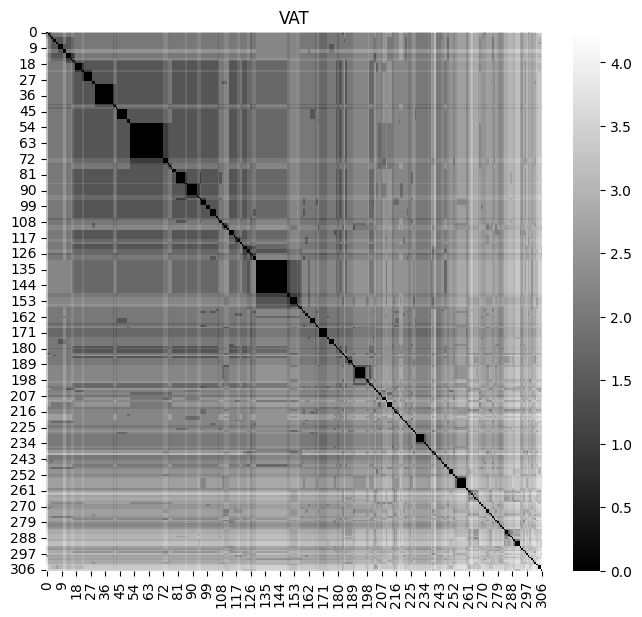

In [279]:
# Plot VAT
RV, _, I = VAT(normalisedBow) # I are the reordered indices

plt.figure(figsize=(8, 7))
sns.heatmap(RV, cmap='gray')
plt.title("VAT")

plt.show()

### assigning right data type to the columns

In [280]:
# specifying the correct data type for each column, the auto configuration by pandas is not accurate because some errors in the dataset
# pandas data types: object, int64, float64, bool, datetime64(ns), timedelta(ns), category
INDEX = 'No. of App.'
FLOAT64 = [
    'Claimed amount (ex GST)', 'Amount of Payment Schedule (ex GST)', 'Adjudicated amount (ex GST)', 'Total Adjudicator fee (ex GST)',
    "Adjudicator's fee payable by Claimant %", "Adjudicator's fee payable by Respondent %",
    "Adjudicator's fee payable by Claimant (ex GST)", "Adjudicator's fee payable by Respondent (ex GST)", 
    'Adjudication Certificate fee (ex GST)'
]

CATEGORY = [
    'Work category', 'Region name', 'Section of Act application made under', 
    'Business Type/Activity (Claimant)', 'Business Structure (Claimant)', 'Claimant advisers',
    'Business Type/Activity (Respondent)', 'Business Structure (Respondent)', 'Respondent advisers',
    'Determination status', 'Reasons if the application is not determined', 's21(2B) new reasons provided by Respondent',
    's22(4)(b) extension of time sought', 'Determination released', 'Adjudication Certificate issued'
]

OBJECT = [
    'Description of project and contract works', 'Project postcode'
]

DATETIME64 = [
    'Application date', 'Acceptance date', 'Determination completion date', 'Determination released date', 'Date Adjudication Certificate issued'
]

In [281]:
# convert other columns to the correct type
for col in FLOAT64:
  df[col] = df[col].astype('float64')
for col in CATEGORY:
  df[col] = df[col].astype('category')
for col in OBJECT:
  df[col] = df[col].astype('object')
for col in DATETIME64:
  df[col] = df[col].astype('datetime64[ns]')

In [282]:
df.dtypes

Application date                                    datetime64[ns]
Acceptance date                                     datetime64[ns]
Description of project and contract works                   object
Project postcode                                            object
Claimed amount (ex GST)                                    float64
Amount of Payment Schedule (ex GST)                        float64
Section of Act application made under                     category
Business Type/Activity (Claimant)                         category
Business Structure (Claimant)                             category
Claimant advisers                                         category
Business Type/Activity (Respondent)                       category
Business Structure (Respondent)                           category
Respondent advisers                                       category
Determination status                                      category
Determination completion date                       datetime64

In [283]:
# Need to differentiate between before the fact information and after the fact information.  
# Fact here being the determination of the adjudication.

BEFORE = [
    'Application date', 'Acceptance date', 'Description of project and contract works', 'Work category', 
    'Project postcode', 'Region name', 'Claimed amount (ex GST)', 'Log claimed amount', 
    'Amount of Payment Schedule (ex GST)', 'Log payment schedule amount', 'Section of Act application made under',
    'Business Type/Activity (Claimant)', 'Business Structure (Claimant)', 'Claimant advisers',
    'Business Type/Activity (Respondent)', 'Business Structure (Respondent)', 'Respondent advisers',
    's21(2B) new reasons provided by Respondent', 's22(4)(b) extension of time sought'
]

FACT = [
    'Determination status', 'Determination completion date', 'Reasons if the application if not determined', 'Determination released',
    'Determination released date'
]

AFTER = [
    'Adjudicated amount (ex GST)', 'Total Adjudicator fee (ex GST)', "Adjudicator's fee payable by Claimant %",
    "Adjudicator's fee payable by Respondent %", "Adjudicator's fee payable by Claimant (ex GST)", "Adjudicator's fee payable by Respondent (ex GST)",
    'Adjudication Certificate issued', 
    'Adjudication Certificate fee (ex GST)', 'Date Adjudication Certificate issued'
]

# Rudimentary Data Analysis

In [284]:
df.columns

Index(['Application date', 'Acceptance date',
       'Description of project and contract works', 'Project postcode',
       'Claimed amount (ex GST)', 'Amount of Payment Schedule (ex GST)',
       'Section of Act application made under',
       'Business Type/Activity (Claimant)', 'Business Structure (Claimant)',
       'Claimant advisers', 'Business Type/Activity (Respondent)',
       'Business Structure (Respondent)', 'Respondent advisers',
       'Determination status', 'Determination completion date',
       'Reasons if the application is not determined',
       's21(2B) new reasons provided by Respondent',
       's22(4)(b) extension of time sought', 'Determination released',
       'Determination released date', 'Adjudicated amount (ex GST)',
       'Total Adjudicator fee (ex GST)',
       'Adjudicator's fee payable by Claimant %',
       'Adjudicator's fee payable by Respondent %',
       'Adjudicator's fee payable by Claimant (ex GST)',
       'Adjudicator's fee payable by Res

## To do list

- [x] adding columns to facilitate our analysis
  - [x] Calculate business day intervals before dates
  - [x] add adjudicated ratio, which will be our main response variable in supervised ML
- [x] NLP to decide whether work done is covered in SOP
- [x] determination ratio of SOP during the period

In [285]:
df['Adjudicate ratio'] = df['Adjudicated amount (ex GST)'] / df['Claimed amount (ex GST)']

In [286]:
# Claimed amount has a very wide range and the higher values are in different magnitudes than rest of others, it seems appropriate to perform a log transformation to it
df['Log claimed amount'] = np.log(df['Claimed amount (ex GST)'] + 1)
df['Log payment schedule amount'] = np.log(df['Amount of Payment Schedule (ex GST)'] + 1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [287]:
# divide data set into 2 groups based on whether determination is reached
# only those that are determined has an adjudicated amount and can be used to fit the model

df_det = df[df['Determination status'] == 'Determined'].copy(deep=True)
df_not_det = df[df['Determination status'] == 'Not determined'].copy(deep=True)

### Calculate business day intervals

In [288]:
#Load the Victorian public holidays
vic_holidays_2021 = holidays.Australia(years=2021, prov='VIC')
vic_holidays_2022 = holidays.Australia(years=2022, prov='VIC')

#Convert them into lists for just the dates
holiday_dates_2021 = list(vic_holidays_2021.keys())
holiday_dates_2022 = list(vic_holidays_2022.keys())

#Create a range of dates for the two years
date_range = pd.date_range(start=datetime.datetime(2021, 1, 1), end=datetime.datetime(2022, 12, 31))

#Filter out the weekends (Saturday and Sunday)
weekends = date_range[date_range.weekday.isin([5, 6])].date

#Create a full list of days that do not count as business days
vic_holidays = sorted(list(set(holiday_dates_2021 + holiday_dates_2022 + list(weekends))))


In [289]:
def calculate_business_days(start_date, end_date):

    "Calculates the number of business days between any two given dates"
    
    # Generate a range of dates
    date_range = pd.date_range(start=start_date, end=end_date).date

    # Filter out all the holidays
    holidays = [date for date in date_range if date in vic_holidays]

    # Calculate the number of business days
    business_days = len(date_range) - len(holidays)
    return business_days

# Calculate the number of business days between the dates
df_det['Business Days between Application and Acceptance'] = df_det.apply(lambda row: calculate_business_days(row['Application date'], row['Acceptance date']), axis=1)
df_det['Business Days between Acceptance and Completion'] = df_det.apply(lambda row: calculate_business_days(row['Acceptance date'], row['Determination completion date']), axis=1)
df_det['Business Days between Completion and Release'] = df_det.apply(lambda row: calculate_business_days(row['Determination completion date'], row['Determination released date']), axis=1)


In [290]:
df_det.columns

Index(['Application date', 'Acceptance date',
       'Description of project and contract works', 'Project postcode',
       'Claimed amount (ex GST)', 'Amount of Payment Schedule (ex GST)',
       'Section of Act application made under',
       'Business Type/Activity (Claimant)', 'Business Structure (Claimant)',
       'Claimant advisers', 'Business Type/Activity (Respondent)',
       'Business Structure (Respondent)', 'Respondent advisers',
       'Determination status', 'Determination completion date',
       'Reasons if the application is not determined',
       's21(2B) new reasons provided by Respondent',
       's22(4)(b) extension of time sought', 'Determination released',
       'Determination released date', 'Adjudicated amount (ex GST)',
       'Total Adjudicator fee (ex GST)',
       'Adjudicator's fee payable by Claimant %',
       'Adjudicator's fee payable by Respondent %',
       'Adjudicator's fee payable by Claimant (ex GST)',
       'Adjudicator's fee payable by Res

Rules:
  - accpetane takes effect when both notice is served to claimant and respondent
    - time difference between 'Application date' and 'Acceptance date'
  - time limit of adjudication
    - an adjudicator is to determine an adjudication application within 10 days after the acceptance date
    - within any further time, not exceeding 15 days after the above date, to which the claimant agrees
    - not quite sure about this, will calculate 
      - time difference between 'Acceptance date' and 'Determination completion date' -> should be this
      - time difference between 'Determination completion date' and 'Determination release date'
  - Adjudicator fee is shared between ANA and Adjudicator, how they share the fee is not a concern to us in terms of the research topic we chose. So will ignore last 3 columns 

## NLP to decide whether the constructed work is covered within the SOP act

In [291]:
COVERED_WORK = """
  (a) the construction, alteration, repair, restoration, maintenance, extension, demolition or dismantling of buildings or structures forming, or to form, part of land (whether permanent or not);
  (b) the construction, alteration, repair, restoration, maintenance, extension, demolition or dismantling of any works forming, or to form, part of land, including walls, roadworks, power-lines, telecommunication apparatus, aircraft runways, docks and harbours, railways, inland waterways, pipelines, reservoirs, water mains, wells, sewers, industrial plant and installations for the purposes of land drainage or coast protection;
  (c) the installation in any building, structure or works of fittings forming, or to form, part of land, including heating, lighting, air-conditioning, ventilation, power supply, drainage, sanitation, water supply, fire protection, security and communications systems;
  (d) the external or internal cleaning of buildings, structures or works, so far as it is carried out in the course of their construction, alteration, repair, restoration, maintenance or extension;
  (e) any operation which forms an integral part of, or is preparatory to or is for rendering complete, work of the kind referred to in paragraph (a), (b) or (c), including—
    (i) site clearance, earth-moving, excavation, tunnelling and boring; and
    (ii) the laying of foundations; and
    (iii) the erection, maintenance or dismantling of scaffolding; and
    (iv) the prefabrication of components to form part of any building, structure or works, whether carried out on-site or off-site; and
    (v) site restoration, landscaping and the provision of roadways and other access works;
  (f) the painting or decorating of the internal or external surfaces of any building, structure or works;
  (g) any other work of a kind prescribed for the purposes of this subsection.
"""

NOT_COVERED_WORK = """
  (a) the drilling for, or extraction of, oil or natural gas;
  (b) the extraction (whether by underground or surface working) of minerals, including tunnelling or boring, or constructing underground works, for that purpose;
  (c) any other work of a kind prescribed for the purposes of this subsection.
"""

In [292]:
df['Project postcode'].value_counts().size

131

In [293]:
import config
openai.api_key = config.API_KEY

In [294]:
# work_performed = input("Please input the work performed")
# place holder for user input
work_performed = 'Supply and install roof downpipes and plumber fit off'

query = f"""Use only information from the below articles on the works covered in Security of Payment (SOP) Act in Victoria, Austrial to answer the subsequent question.
The first article is about works covered under SOP. The second is about works not covered.
Only answer with "covered" or "not covered".
If you cannot decide, answer with "The work done is not relevant".

Article:
\"\"\"
{COVERED_WORK}
\"\"\"
\"\"\"
{NOT_COVERED_WORK}
\"\"\"

Question: is {work_performed} covered in Security of Payment"""

MODEL = "gpt-3.5-turbo"
response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "user", "content": query},
    ],
    temperature=0,
)

response['choices'][0]['message']['content']

'covered'

In [295]:
works = list(df['Description of project and contract works'].values)

In [296]:
# query = f"""The article given below listed the types of work covered in Security of Payment act.
# These categories are labeled using character from a to g.

# Article:
# \"\"\"
# {COVERED_WORK}
# \"\"\"

# Based only on the information given above, for each of the project decription (seperated by ,) in the list given below, please classify each of them to a category from (a) to (g).
# Output the result in a single string, wrap each categorisation with single quote and separate each with comma (,).
# Notice the output should only contain characters "a, b, c, d, e, f, g"

# the project descriptions: {works}"""

# MODEL = "gpt-3.5-turbo"
# response = openai.ChatCompletion.create(
#     model=MODEL,
#     messages=[
#         {"role": "user", "content": query},
#     ],
#     temperature=0,
# )

# response

## small ideas

In [297]:
# overall determination ratio of SOP act during the period
determination_ratio = df_det.shape[0] / df.shape[0]
determination_ratio

0.6188925081433225

In [298]:
# distribution of Adjudication Certificate fee (4 levels: 0, 100, 300, 500)

In [299]:
# distribution of share%

In [300]:
# The SOP act does not charge application fee as evidenced by all the cases in our dataset.

# Visualisation

## To do list

- most of the time for distribution it's just the univariate distribution of of variable, so histogram should be fine
- our main response variable would be 
$$ adjudicated\ ratio = \frac{adjudicated\ amount}{claimed\ amount} $$

-----

- [ ] distribution of Adjudication Certificate fee (4 levels: 0, 100, 300, 500)
- [ ] distribution of Claimed amount
- [ ] distribution of adjudicated amount/claimed amount
- [ ] distribution of adjudicated fee/adjudicated amount
- [ ] exploration of our (main) response variable to potential predictors, mostly 2D scatter plot, if you find something interesting and needs to put them in one graph, could use 3D scatter plot, augment the graph with size (of dot), color, etc
  - [ ] main response against every potential predictor, show the interesting ones
  - [ ] other response aginst every potential predictor, show the interesting ones
- [ ] heatmap to see if we can cluster our dataset into different groups (unsupervised ML)

Flow chart of the application process (timeline) - Do we summarise the SOP flowchart on the edworksspace Jonas Sun provided using another flowchart? 

Distribution of claimed amount/PC business type/R business type - Do we plot it against the application date or acceptance data etc.? Will probably use bar chart, any other ideas for categorical data?

Any other visualisations we need?

If we did clustering, what would we base it on



In [301]:
# heatmap
df.columns

Index(['Application date', 'Acceptance date',
       'Description of project and contract works', 'Project postcode',
       'Claimed amount (ex GST)', 'Amount of Payment Schedule (ex GST)',
       'Section of Act application made under',
       'Business Type/Activity (Claimant)', 'Business Structure (Claimant)',
       'Claimant advisers', 'Business Type/Activity (Respondent)',
       'Business Structure (Respondent)', 'Respondent advisers',
       'Determination status', 'Determination completion date',
       'Reasons if the application is not determined',
       's21(2B) new reasons provided by Respondent',
       's22(4)(b) extension of time sought', 'Determination released',
       'Determination released date', 'Adjudicated amount (ex GST)',
       'Total Adjudicator fee (ex GST)',
       'Adjudicator's fee payable by Claimant %',
       'Adjudicator's fee payable by Respondent %',
       'Adjudicator's fee payable by Claimant (ex GST)',
       'Adjudicator's fee payable by Res

In [317]:
df['Section of Act application made under'].value_counts()

s.18(1)(b)        151
s.18(1)(a)(i)     142
s.18(1)(a)(ii)     14
Name: Section of Act application made under, dtype: int64

# Feature Selection

In [302]:
# relationship between categorical variables using mutual information or Cramer's V

### Pearson's correlation

In [303]:
# Pearson correlation (only applicable to numerical values)
df_det[BEFORE + ['Adjudicate ratio']].corr()

/var/folders/zk/5ftd784d7k98ng_cj8kjv5680000gn/T/ipykernel_59440/3813966535.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_det[BEFORE + ['Adjudicate ratio']].corr()


,Claimed amount (ex GST),Log claimed amount,Amount of Payment Schedule (ex GST),Log payment schedule amount,Adjudicate ratio
Claimed amount (ex GST),1.000000,0.406522,-0.002035,-0.033686,-0.050638
Log claimed amount,0.406522,1.000000,0.226352,0.134641,-0.045719
Amount of Payment Schedule (ex GST),-0.002035,0.226352,1.000000,0.600945,0.059330
Log payment schedule amount,-0.033686,0.134641,0.600945,1.000000,-0.053801
Adjudicate ratio,-0.050638,-0.045719,0.059330,-0.053801,1.000000


We will not rely too much on Pearson's correlation because:
  1. Except for the response varialbe 'Adjudicate ratio', we only have two potential predictors that are numerical.
  2. The model we attempt to use is Beta regression which is not a linear model while Pearson's correlation only tells us about how two variables are linearly correlated.

Nevertheless, it is good to see the correlation between 'Adjudicate ratio' and 'Claimed amount' is extremely close to 0 which means the adjudication is not affected by the amount Claimed which might suggest the process is just and unbiased.

### Mutual Information

In [304]:
# discretize adjudicate ratio to facilitate the calculation of mutual information
def discretize_perc(perc):
  """
  by examining the distribution, most of the application's adjudicate ratio is clustered around 0 or 1
  so we really don't care too much anything in between as long as the data can be corretly classified to the low or high end of %
  so for now, we just create 4 equal length bins
  """
  if perc < 0.25: return 'L'
  elif perc < 0.5: return 'ML'
  elif perc < 0.75: return 'MH'
  else: return 'H'

df_det['Adjudicate ratio bin'] = df_det['Adjudicate ratio'].apply(discretize_perc)
df_det['Adjudicate ratio bin'] = df_det['Adjudicate ratio bin'].astype('category')

In [305]:
def binary_perc(perc):
    if perc < 0.5: return 0
    return 1
    
df_det['Adjudicate ratio binary'] = df_det['Adjudicate ratio'].apply(binary_perc)
df_det['Adjudicate ratio binary'] = df_det['Adjudicate ratio binary'].astype('int64')

In [308]:
BEFORE_CATEGORY = list(set(BEFORE) & set(CATEGORY))

In [316]:
from sklearn.metrics import normalized_mutual_info_score

def NMI_category_list(response):
    variables = BEFORE_CATEGORY + [response]
    length = len(variables)
    print("NMI between categorical variables")
    print("{:<80} {:<10}".format('variable','NMI'))
    for i in range(length):
        for j in range(i+1, length):
            score = normalized_mutual_info_score(df_det[variables[i]], df_det[variables[j]], average_method='min')
            if score > 0.15:
                print("{:<80} {:<10.2f}".format(variables[i]+':'+variables[j], score))
    
NMI_category_list('Adjudicate ratio bin')


NMI between categorical variables
variable                                                                         NMI       
Respondent advisers:Business Type/Activity (Claimant)                            0.19      
Respondent advisers:s21(2B) new reasons provided by Respondent                   0.23      
Respondent advisers:s22(4)(b) extension of time sought                           0.19      
Work category:Business Type/Activity (Claimant)                                  0.16      
Work category:Business Structure (Claimant)                                      0.22      
Section of Act application made under:s21(2B) new reasons provided by Respondent 0.17      
Section of Act application made under:Business Structure (Claimant)              0.15      
Section of Act application made under:s22(4)(b) extension of time sought         0.17      
Claimant advisers:Region name                                                    0.15      
Business Type/Activity (Respondent):Business T

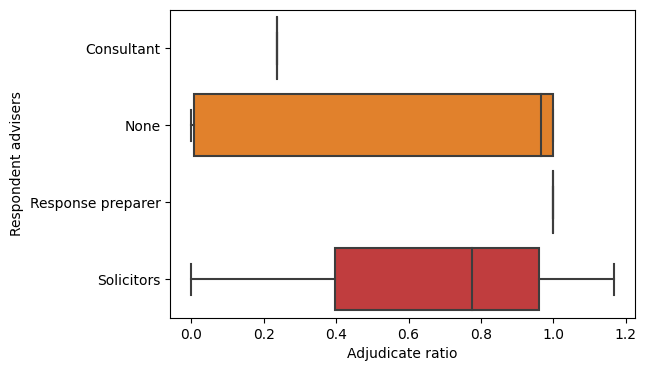

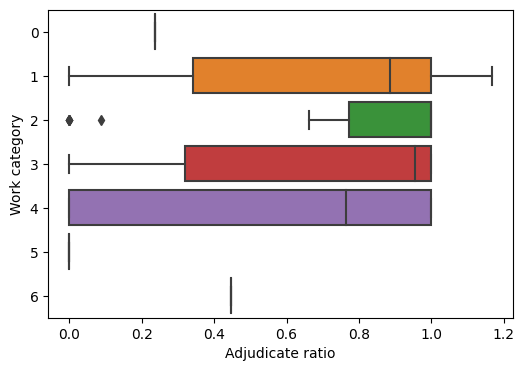

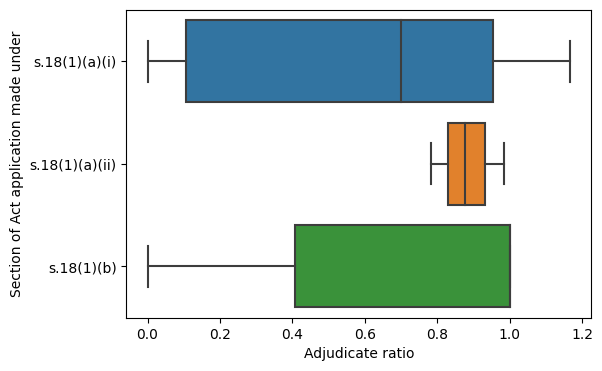

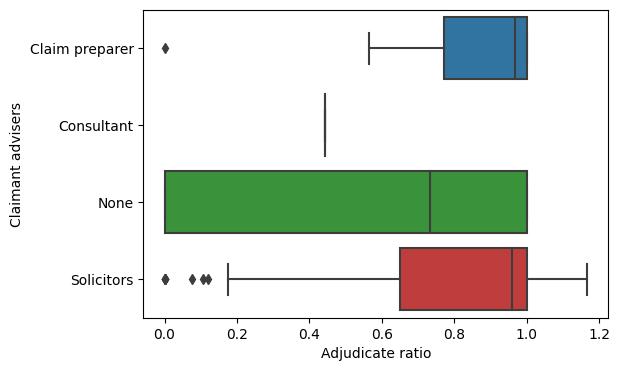

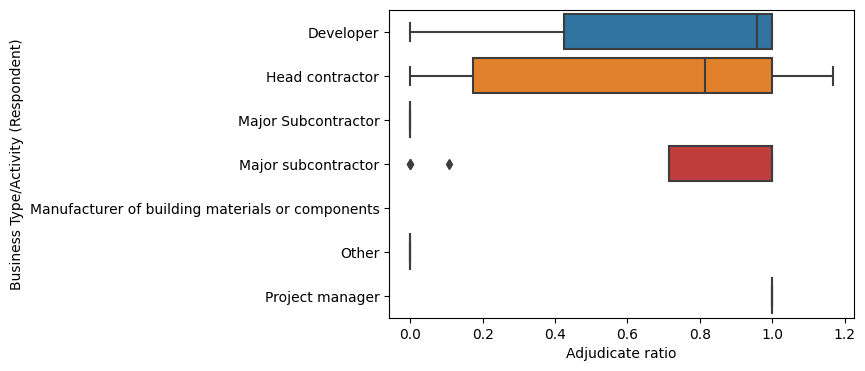

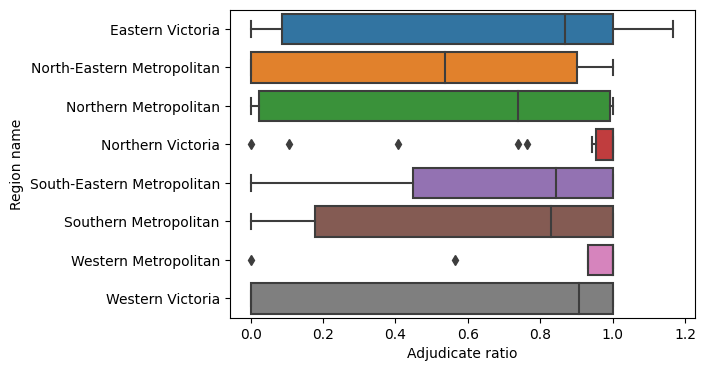

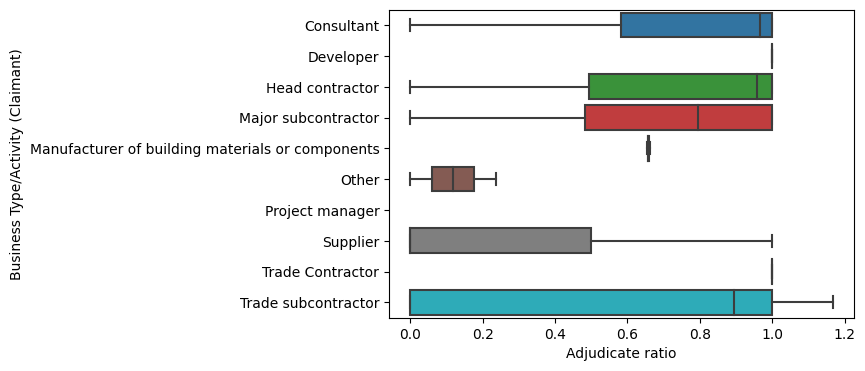

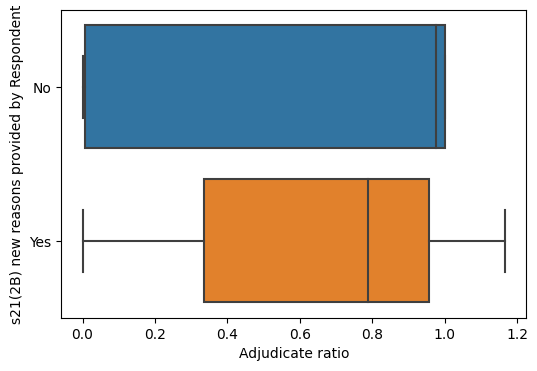

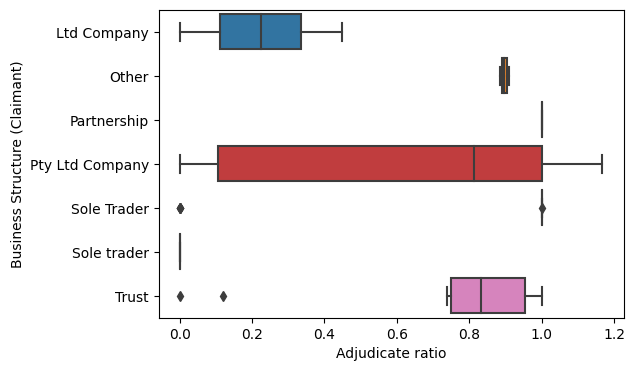

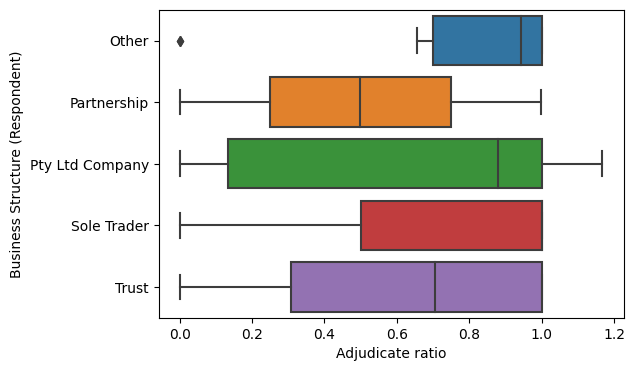

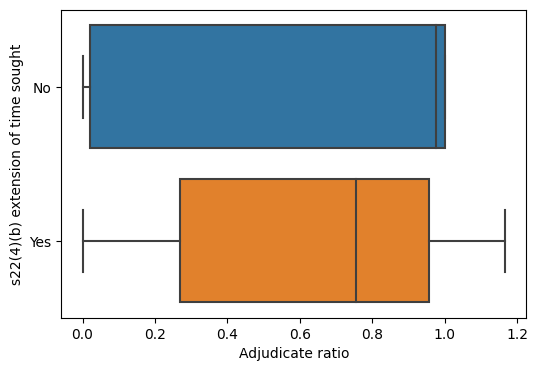

In [311]:
def pairwise_rel():
#     f = plt.figure(figsize=(6, 12))
#     gs = f.add_gridspec(3, 3)
#     i = 0
    for col in BEFORE_CATEGORY:
        # ax = f.add_subplot(gs[i//3, i%3])
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(ax=ax, data=df_det, y=col, x="Adjudicate ratio")
        # i += 1

pairwise_rel()

In [312]:
# BEFORE_CATEGORY = list(set(BEFORE) & set(CATEGORY))

# g = sns.PairGrid(df_det, vars=BEFORE_CATEGORY + ['Adjudicate ratio'])
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.stripplot)

# Model Fitting

In [313]:
df_det.loc[df_det['Adjudicate ratio'] > 1, ]

,Application date,Acceptance date,Description of project and contract works,Project postcode,Claimed amount (ex GST),Amount of Payment Schedule (ex GST),Section of Act application made under,Business Type/Activity (Claimant),Business Structure (Claimant),Claimant advisers,...,Description of work processed,Work category,Adjudicate ratio,Log claimed amount,Log payment schedule amount,Business Days between Application and Acceptance,Business Days between Acceptance and Completion,Business Days between Completion and Release,Adjudicate ratio bin,Adjudicate ratio binary
No. of App.,,,,,,,,,,,,,,,,,,,,,
185,2022-02-10,2022-02-14,Construction works,3910,19517.24,0.0,s.18(1)(a)(i),Trade subcontractor,Pty Ltd Company,Solicitors,...,construction works,1,1.167632,9.879105,0.0,3,17,1,H,1


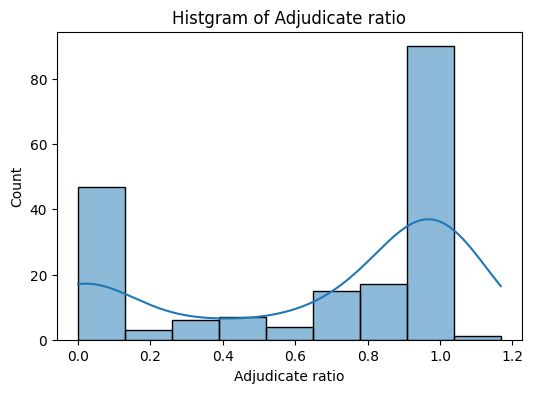

In [314]:
# plot to see how is 'Adjudicate ratio' distributed
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df_det['Adjudicate ratio'], kde=True, ax=ax)
ax.set_title('Histgram of Adjudicate ratio')
fig.savefig('plots/AdjudicateRatioHist.png')

As expected, percentage data is usually highly skewed and does not fit too well into a traditional linear regression model while beta regression can alleviate the problem of skewness through a proper choice of link function

In [315]:
BEFORE

['Application date',
 'Acceptance date',
 'Description of project and contract works',
 'Work category',
 'Project postcode',
 'Region name',
 'Claimed amount (ex GST)',
 'Log claimed amount',
 'Amount of Payment Schedule (ex GST)',
 'Log payment schedule amount',
 'Section of Act application made under',
 'Business Type/Activity (Claimant)',
 'Business Structure (Claimant)',
 'Claimant advisers',
 'Business Type/Activity (Respondent)',
 'Business Structure (Respondent)',
 'Respondent advisers',
 's21(2B) new reasons provided by Respondent',
 's22(4)(b) extension of time sought']

In [233]:
df.to_csv("cleaned_full_data.csv")
df_det.to_csv("cleaned_det_data.csv")

### structural zero issues

In [65]:
df_det['Business Structure (Respondent)'].value_counts()

Pty Ltd Company    166
Other               13
Trust                6
Sole Trader          3
Partnership          2
Name: Business Structure (Respondent), dtype: int64

In [66]:
df_det.loc[df_det['Business Structure (Respondent)'] == 'Other', ]

,Application date,Acceptance date,Description of project and contract works,Project postcode,Claimed amount (ex GST),Amount of Payment Schedule (ex GST),Section of Act application made under,Business Type/Activity (Claimant),Business Structure (Claimant),Claimant advisers,...,Date Adjudication Certificate issued,Region name,Description of work processed,Work category,Adjudicate ratio,Business Days between Application and Acceptance,Business Days between Acceptance and Completion,Business Days between Completion and Release,Adjudicate ratio bin,Adjudicate ratio binary
No. of App.,,,,,,,,,,,,,,,,,,,,,
71,2021-08-31,2021-09-06,Electrical Works (new pits and metering),3581,37224.39,0.00,s.18(1)(b),Trade subcontractor,Pty Ltd Company,Solicitors,...,2021-10-27,Northern Victoria,electrical works new pits metering,4,1.000000,5,14,1,H,1
80,2021-09-07,2021-09-09,Excavation works,3212,32928.00,NaN,s.18(1)(b),Trade subcontractor,Pty Ltd Company,None,...,2021-10-05,Western Victoria,excavation works,4,1.000000,3,10,2,H,1
91,2021-09-21,2021-09-23,Excavation works,3228,8500.00,NaN,s.18(1)(b),Trade subcontractor,Pty Ltd Company,None,...,NaT,Western Victoria,excavation works,4,0.000000,3,7,1,L,0
113,2021-10-26,2021-10-29,Plumbing and roofing works,3189,12553.04,NaN,s.18(1)(b),Trade subcontractor,Sole trader,None,...,NaT,Southern Metropolitan,plumbing roofing works,4,0.000000,4,10,3,L,0
124,2021-11-16,2021-11-22,Bridge replacement,3351,19300.18,NaN,s.18(1)(b),Head contractor,Pty Ltd Company,Claim preparer,...,NaT,Western Victoria,bridge replacement,0,1.000000,5,16,3,H,1
155,2021-12-22,2021-12-23,Construction works,3186,203517.80,0.00,s.18(1)(a)(i),Head contractor,Pty Ltd Company,Solicitors,...,NaT,Southern Metropolitan,construction works,4,0.829458,2,14,14,H,1
156,2021-12-22,2021-12-23,Construction works,3186,193029.75,0.00,s.18(1)(a)(i),Head contractor,Pty Ltd Company,Solicitors,...,NaT,Southern Metropolitan,construction works,4,0.699764,2,14,14,MH,1
230,2022-04-05,2022-04-06,Electrical supply and installation,3996,5004.55,0.00,s.18(1)(a)(i),Head contractor,Pty Ltd Company,None,...,2022-05-02,Eastern Victoria,electrical supply installation,0,1.000000,2,11,1,H,1
240,2022-04-10,2022-04-14,Steel Fabrication,3195,31280.64,0.00,s.18(1)(a)(i),Manufacturer of building materials or components,Pty Ltd Company,None,...,NaT,South-Eastern Metropolitan,steel fabrication,6,0.654563,4,13,3,MH,1


### Model 1: beta regression
motivation: as a criteria to help PC decide whether he should use the service
- response: % of the claimed amount adjudicated
- predictor: TBD

### Model 2: beta regression
motivation: as a criteria to help PC decide whether he should use the service
- response: % of the claimed amount adjudicated
- predictor: TBD

### Model 3: multinomial logistic regression
motivation: try to predict the Certificate fee if PC choose to have one issued.reverse engineering how the government calculates this fee.   
46 cases.
- response: Adjudication Certificate fee
  - currently has 4 levels: 0, 100, 300, 500
- predictor: TBD

### Model 4: binomial logistic regression
movitation: predict whether a case would end up being determined.  
limitation: 
- response: determination status: determined vs. not determined
- predictor: TBD

# Limitation and Future Improvement

- The preprocessing is not very robust.
  - The logical relationship between varialbe is very intricate and intertwined which makes the ordering of our preprocessing very vulnerable. A single switch of ordering between steps could render following steps unfunctional. 
  - This signals that our preprocessing is not very robust and is too specific to our dataset to generalize to other datasets.
  - On the other hand, the nature of our preprocessing is highly accurate which satisfied both legal requirement and logical constraints instead of just dealing with missing values and mis-inputs. 
  - So it's really hard to strike a balance between robustness and accuracy.
  
- 

# Code dustbin

## preprocessing

number data format: This problem is probably due to Mac-version excel, everything is fine when you convert it to pandas or view it on windows excel.

In [67]:
# 'Payment Schedule provision' to lowercase
# df['Payment Schedule provision'] = df['Payment Schedule provision'].apply(lambda x: x.lower() if type(x) == str else x)

In [68]:
# locate "withheld" in column 'Adjudicated amount (ex GST)' and 'Total Adjudicator fee (ex GST)' 
# in row 58 199 312
# delete 3 rows 
# df = df.drop(df.loc[df['Adjudicated amount (ex GST)'] == 'Withheld'].index)

In [69]:
# preprocessing: number format in the dataset is wrong
# eg: all the numbers are like 5.727,27
# thousand separator and decimal points are swapped

# # TODO: write code to fix this
# for col in FLOAT64:
#   for i, entry in enumerate(df[col]):
#     try:
#       if type(entry) == 
#         df[col][i] = re.sub('[,.]', '', entry)
#     except TypeError:
#       print("col: ", col, "entry: ", entry)
#   # try:
#   #   df_det[col] = [re.sub('[,.]', '', n) for if type(n) n in df_det[col]]
#   # except TypeError:
#   #   print("the problematic col is: ", col)